In [1]:
# Imports
import pandas as pd
import numpy as np
import psycopg2
import time
from time import gmtime, strftime

In [3]:
# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.font_manager
import seaborn as sns

%matplotlib inline

In [4]:
plt.style.use('ggplot')

plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#505050'
plt.rcParams['axes.labelcolor']= '#505050'
plt.rcParams['xtick.color'] = '#505050'
plt.rcParams['ytick.color'] = '#505050'
plt.rcParams['font.size']= 11

In [5]:
def countplot_frequency(df, column_name, title, order=None):
    ax = sns.countplot(x=column_name, data=df, order=order)
    plt.title(title)

    # Make twin axis
    ax2 = ax.twinx()

    # Switch so count axis is on right, frequency on left
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    # Also switch the labels over
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Frequency [%]')

    ncount = len(df)
    for p in ax.patches:
        x = p.get_bbox().get_points()[:,0]
        y = p.get_bbox().get_points()[1,1]
        ax.annotate('{:.2f}%'.format(100.*y/ncount), (x.mean(), y), ha='center', va='bottom') # set the alignment of the text

    # Use a LinearLocator to ensure the correct number of ticks
    ax.yaxis.set_major_locator(mtick.LinearLocator(11))

    # Fix the frequency range to 0-100
    ax2.set_ylim(0, 100)
    ax.set_ylim(0, ncount)

    # And use a MultipleLocator to ensure a tick spacing of 10
    ax2.yaxis.set_major_locator(mtick.MultipleLocator(10))

    # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
    ax2.grid(None)
    return ax, ax2

### POSTGRESQL

In [6]:
# Notebook
# host = '/tmp'

# Locus
host = '/var/run/postgresql'

con = psycopg2.connect(dbname ='mimic', user='postgres', password="*2465RMLbru", host=host)
cur = con.cursor()

### ICD-9 Codes table

In [7]:
diagnoses_query = '''SELECT * FROM mimiciii.diagnoses_icd;'''
mimic_diagnoses_df = pd.read_sql_query(diagnoses_query, con)

### ICD-9 Descriptions table

In [8]:
diagnoses_descriptions_query = '''SELECT * FROM mimiciii.d_icd_diagnoses;'''
mimic_diagnoses_descriptions_df = pd.read_sql_query(diagnoses_descriptions_query, con)

### ICU Stays (patients details)

link:
https://github.com/MIT-LCP/mimic-code/blob/master/tutorials/cohort-selection.ipynb

"As MIMIC-III is primarily an intensive care unit (ICU) database, the focus will be on patients admitted to and discharged from the ICU. That is, rather than selecting our cohort based off the individual patient (identified by subject_id in the database), we will usually want to select our cohort based off the ICU stay (identified by icustay_id). Thus, it is sensible to begin with the icustays table."

In [10]:
icustay_query = 'SELECT * FROM mimiciii.icustay_detail_v2;' 
icustay_details_df = pd.read_sql_query(icustay_query, con)

In [11]:
def normalize_insurance(ins):
    if ins in ['Government', 'Medicaid', 'Medicare']:
        return 'Public'
    elif ins == 'Private':
        return 'Private'
    else:
        return 'Self-Pay'
    
# We are not considering MULTI RACE ETHNICITY, NATIVE, UNKNOWN or OTHER 
icustay_details_df = icustay_details_df[(icustay_details_df['ethnicity_grouped'] != 'other') & (icustay_details_df['ethnicity_grouped'] != 'unknown') & (icustay_details_df['ethnicity_grouped'] != 'native')]

# +18 years old (300 years old are patients older than 89)
icustay_details_df = icustay_details_df[(icustay_details_df['age'] >= 18) & (icustay_details_df['age'] < 300)]

# insurance
icustay_details_df['insurance'] = icustay_details_df['insurance'].apply(normalize_insurance)

# icd9 merge
icu_diagnoses_df = pd.merge(icustay_details_df, mimic_diagnoses_df, on = ['subject_id', 'hadm_id'], how = 'inner')

In [12]:
eth_mortality_df = icu_diagnoses_df.groupby(['icd9_code', 'ethnicity_grouped', 'hospital_expire_flag']).size().unstack()
eth_mortality_df = eth_mortality_df.reset_index()
eth_mortality_df.columns.names = [None]
eth_mortality_df.columns = ['icd9_code', 'ethnicity', 'alive', 'dead']
eth_mortality_df.insert(4, 'total', '0')
eth_mortality_df = eth_mortality_df.fillna(0)
eth_mortality_df['total'] = eth_mortality_df['total'].astype(float)

# Compute alive, dead and total
for index, row in eth_mortality_df.iterrows():
    eth_mortality_df.at[index, 'total'] = row['alive'] + row['dead']

In [13]:
# merge mortality with descriptions from each ICD
eth_mortality_df = eth_mortality_df.merge(mimic_diagnoses_descriptions_df, left_on='icd9_code', right_on='icd9_code')

#### Transplanted patients

In [14]:
# Search only for patients with transplant description
transplanted_patients_df = eth_mortality_df[eth_mortality_df['long_title'].str.lower().str.contains('transplant')].copy()

# 1. Mortality significance: only +1 patients dead
transplanted_patients_df = transplanted_patients_df.loc[eth_mortality_df['dead'] > 1]

# 2. Remove ICD9 codes with only ONE ETHNICITY
for index, row in transplanted_patients_df.iterrows():
    rows = transplanted_patients_df.loc[transplanted_patients_df['icd9_code'] == row['icd9_code']]
    if (len(rows) == 1):
        transplanted_patients_df.drop(rows.index, inplace=True)
        
transplanted_patients_df = transplanted_patients_df.drop(['row_id', 'short_title'], axis=1)

#### Cancer

In [15]:
searchfor = ['neoplasm', 'neoplasms', 'sarcoma', 'carcinoma']
cancer_patients_df = eth_mortality_df[eth_mortality_df['long_title'].str.lower().str.contains('|'.join(searchfor))].copy()

# 1. Mortality significance: only +1 patients dead
cancer_patients_df = cancer_patients_df.loc[cancer_patients_df['dead'] > 1]

# 2. Remove ICD9 codes with only ONE ETHNICITY
for index, row in cancer_patients_df.iterrows():
    rows = cancer_patients_df.loc[cancer_patients_df['icd9_code'] == row['icd9_code']]
    if (len(rows) == 1):
        cancer_patients_df.drop(rows.index, inplace=True)
        
cancer_patients_df = cancer_patients_df.drop(['row_id', 'short_title'], axis=1)


#### Diabetes

In [16]:
diabetes_patients_df = eth_mortality_df[eth_mortality_df['long_title'].str.lower().str.contains('diabetes')].copy()

# 1. Mortality significance: only +1 patients dead
diabetes_patients_df = diabetes_patients_df.loc[diabetes_patients_df['dead'] > 1]

# 2. Remove ICD9 codes with only ONE ETHNICITY
for index, row in diabetes_patients_df.iterrows():
    rows = diabetes_patients_df.loc[diabetes_patients_df['icd9_code'] == row['icd9_code']]
    if (len(rows) == 1):
        diabetes_patients_df.drop(rows.index, inplace=True)
        
diabetes_patients_df = diabetes_patients_df.drop(['row_id', 'short_title'], axis=1)

#### Select admissions

In [17]:
icd9_list = set(transplanted_patients_df['icd9_code'])
icd9_list.update(cancer_patients_df['icd9_code'])
icd9_list.update(diabetes_patients_df['icd9_code'])

hadm_ids_list = set()

for icd9 in icd9_list:    
    patients = icu_diagnoses_df.loc[(icu_diagnoses_df["icd9_code"] == icd9)].copy()
    for hadm_id in patients['hadm_id']:
        hadm_ids_list.add(hadm_id)

### Oasis score

Oxford Acute Severity of Illness Score (OASIS)
- This score is a measure of severity of illness for patients in the ICU.
- The score is calculated on the first day of each ICU patients' stay.

Variables used in OASIS:
-  Heart rate, GCS, MAP, Temperature, Respiratory rate, Ventilation status (sourced from CHARTEVENTS)
-  Urine output (sourced from OUTPUTEVENTS)
-  Elective surgery (sourced from ADMISSIONS and SERVICES)
-  Pre-ICU in-hospital length of stay (sourced from ADMISSIONS and ICUSTAYS)
-  Age (sourced from PATIENTS)

In [18]:
# Get the OASIS scores (ONLY IF PATIENT WAS ADMITTED TO THE ICU(intensive care unit))
oasis_query = 'SELECT distinct hadm_id, max(oasis) as oasis FROM mimiciii.oasis GROUP BY hadm_id'
oasis_df = pd.read_sql_query(oasis_query, con)

In [19]:
# Scores
# Low: 0-32
# Medium: 33-40
# High: 41+
def select(scores):
    low, medium, high = [], [], []
    for hadm_id in hadm_ids_list:
        if scores[hadm_id] < 33:
            low.append(hadm_id)
        elif scores[hadm_id] < 41:
            medium.append(hadm_id)
        else:
            high.append(hadm_id)
    return low, medium, high

oasis_scores = dict(oasis_df[['hadm_id','oasis']].values)
pat_oasis_score_low, pat_oasis_score_medium, pat_oasis_score_high = select(oasis_scores)

In [20]:
print(len(pat_oasis_score_low), len(pat_oasis_score_medium), len(pat_oasis_score_high))

9737 4613 2807


### Cohort

In [21]:
print(time.strftime("%Y-%m-%d %H:%M:%s"))

cohort_low_df = pd.DataFrame()
cohort_medium_df = pd.DataFrame()
cohort_high_df = pd.DataFrame()

for hid in pat_oasis_score_low:
    patients = icu_diagnoses_df.loc[(icu_diagnoses_df["hadm_id"] == hid)].copy()
    cohort_low_df = cohort_low_df.append(patients, ignore_index=True)
    
for hid in pat_oasis_score_medium:
    patients = icu_diagnoses_df.loc[(icu_diagnoses_df["hadm_id"] == hid)].copy()
    cohort_medium_df = cohort_medium_df.append(patients, ignore_index=True)
    
for hid in pat_oasis_score_high:
    patients = icu_diagnoses_df.loc[(icu_diagnoses_df["hadm_id"] == hid)].copy()
    cohort_high_df = cohort_high_df.append(patients, ignore_index=True)

print(time.strftime("%Y-%m-%d %H:%M:%s"))

2019-11-21 11:29:1574346565
2019-11-21 11:40:1574347225


In [22]:
# REMOVE: same admission multiple times for different ICD9
cohort_low_df.drop_duplicates(subset='hadm_id', keep='last', inplace=True)
cohort_medium_df.drop_duplicates(subset='hadm_id', keep='last', inplace=True)
cohort_high_df.drop_duplicates(subset='hadm_id', keep='last', inplace=True)

In [65]:
cohort_low_df['oasis_score'] = 1
cohort_medium_df['oasis_score'] = 2
cohort_high_df['oasis_score'] = 3

In [124]:
# Join all cohorts
cohort_df = pd.DataFrame()
cohort_df = cohort_df.append(cohort_low_df, ignore_index=True)
cohort_df = cohort_df.append(cohort_medium_df, ignore_index=True)
cohort_df = cohort_df.append(cohort_high_df, ignore_index=True)

### MIMIC III Population characteristics

In [110]:
# Pollard TJ, Johnson AEW, Raffa JD, Mark RG (2018). tableone: An open source
# Python package for producing summary statistics for research papers.
# JAMIA Open, Volume 1, Issue 1, 1 July 2018, Pages 26-31.
# https://doi.org/10.1093/jamiaopen/ooy012
    
# Table One
from tableone import TableOne

# optionally, a categorical variable for stratification
groupby = ['ethnicity_grouped']

# columns to be summarized
columns = ['gender', 'insurance','los_hospital', 'age'] 

# columns containing categorical variables
categorical = ['gender', 'insurance']

# non-normal variables
nonnormal = ['age', 'los_hospital']

# alternative labels
labels={'los_hospital': 'Length of Stay', 'age': 'Age', 'ethnicity_grouped':'Ethnicity',
        'gender':'Gender', 'insurance':'Insurance'}

# combine all information
grouped_df = cohort_df

# create an instance of TableOne with the input arguments
grouped_table = TableOne(grouped_df, columns, categorical, groupby, nonnormal, rename=labels, missing=False)

# view tableone
grouped_table

Grouped by Ethnicity                                                      
                                       asian             black          hispanic             white
n                                        504              2367               738             13548
Gender         F                  197 (39.1)       1326 (56.0)        302 (40.9)       5693 (42.0)
               M                  307 (60.9)       1041 (44.0)        436 (59.1)       7855 (58.0)
Insurance      Private            100 (19.8)        467 (19.7)        129 (17.5)       3960 (29.2)
               Public             403 (80.0)       1887 (79.7)        599 (81.2)       9553 (70.5)
               Self-Pay              1 (0.2)          13 (0.5)          10 (1.4)          35 (0.3)
Length of Stay                7.5 [4.2,13.0]    7.0 [4.0,12.0]    6.5 [4.1,12.0]    7.5 [4.6,12.7]
Age                         66.4 [56.5,76.8]  63.9 [53.9,73.1]  60.2 [50.0,70.5]  68.6 [58.8,77.8]
[1] Warning, Hartigan's Dip Test reports possible multimodal distributions for: los_hospital.
[2] Warning, Tukey test indicates far outliers in: los_hospital.
[3] Warning, test for normality reports non-normal distributions for: age, los_hospital.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fde6f569710>,
      dtype=object)

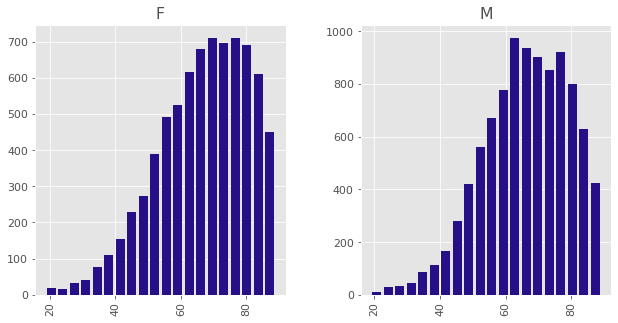

In [111]:
# Total (by gender)
cohort_df.hist(column='age', by='gender', bins=20, color='#271087', zorder=2, rwidth=0.8, figsize=(10, 5))


(<matplotlib.axes._subplots.AxesSubplot at 0x7fde71c92048>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fde71ca9208>)

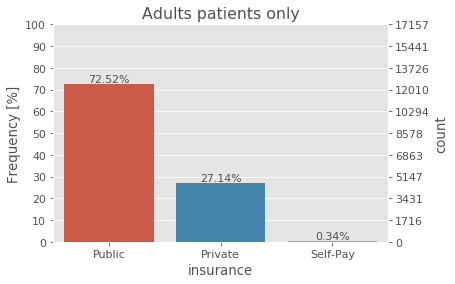

In [112]:
# Total (by insurance)
countplot_frequency(cohort_df, 'insurance', 'Adults patients only')


Text(0, 0.5, 'Density')

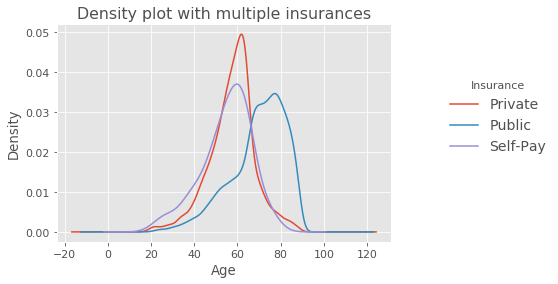

In [113]:
# Insurance by age
cohort_df.groupby('insurance')['age'].plot(kind='density')

plt.legend(prop={'size': 14}, title = 'Insurance', frameon=False, bbox_to_anchor=(1.5, 0.8))
plt.title('Density plot with multiple insurances')
plt.xlabel('Age')
plt.ylabel('Density')

Text(0, 0.5, '# patients')

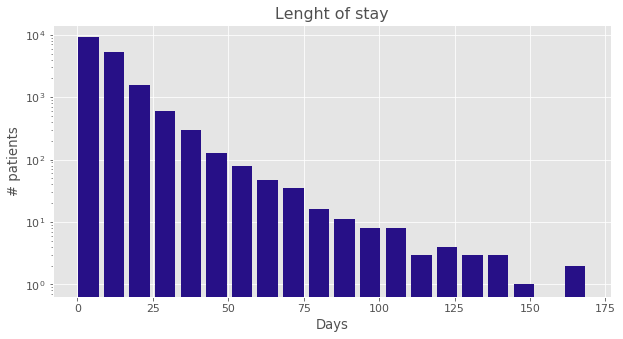

In [114]:
# Lenght of stay
cohort_df.hist(column='los_hospital', bins=20, color='#271087', grid=True, zorder=2, rwidth=0.8, figsize=(10, 5))

plt.yscale('log')
plt.title('Lenght of stay')
plt.xlabel('Days')
plt.ylabel('# patients')

### Cox Regression

"Survival Analysis is used to estimate the lifespan of a particular population under study. It is also called ‘Time to Event’ Analysis as the goal is to estimate the time for an individual or a group of individuals to experience an event of interest. This time estimate is the duration between birth and death events. Survival Analysis was originally developed and used by Medical Researchers and Data Analysts to measure the lifetimes of a certain population."

In [125]:
cohort_df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'gender', 'dod', 'admittime',
       'dischtime', 'insurance', 'los_hospital', 'age', 'ethnicity',
       'ethnicity_grouped', 'admission_type', 'hospital_expire_flag',
       'hospstay_seq', 'first_hosp_stay', 'intime', 'outtime', 'los_icu',
       'icustay_seq', 'first_icu_stay', 'row_id', 'seq_num', 'icd9_code',
       'oasis_score'],
      dtype='object')

In [126]:
# Select features
cohort_df.set_index('hadm_id')
cohort_df['dod'] = cohort_df['dod'].values.astype(float)

features = ['hadm_id', 'gender', 'dod', 'insurance', 'los_hospital', 'age', 
            'ethnicity_grouped', 'admission_type', 'hospital_expire_flag', 
            'icd9_code', 'oasis_score']

In [127]:
# Convert categorical variables to numerical encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
cat_col = ['gender', 'insurance', 'ethnicity_grouped', 'admission_type', 'icd9_code', 'oasis_score']

cohort = cohort_df.copy()
cohort[cat_col] = cohort[cat_col].apply(le.fit_transform)

In [139]:
#cohort_df.head()

In [140]:
#cohort.head()

In [103]:
from lifelines import CoxPHFitter

# event status: hospital_expire_flag (died in hospital or not)
# duration: los_hospital (hospital lenght of stay -- in days)

cph = CoxPHFitter()

# TODO: 
# https://github.com/CamDavidsonPilon/lifelines/blob/master/examples/Cox%20residuals.ipynb
# https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html
# https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html

strata = []

cph.fit(cohort[features], duration_col='los_hospital', event_col='hospital_expire_flag', strata=strata, show_progress=True)

Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -16578.97030, newton_decrement = 0.00000, seconds_since_start = 1.3Convergence completed after 7 iterations.


<lifelines.CoxPHFitter: fitted with 17157 total observations, 15092 right-censored observations>

In [138]:
# Access the results
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 17157 total observations, 15092 right-censored observations>
             duration col = 'los_hospital'
                event col = 'hospital_expire_flag'
   number of observations = 17157
number of events observed = 2065
   partial log-likelihood = -16578.97
         time fit was run = 2019-11-21 19:54:23 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
hadm_id             0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
gender              0.01       1.01       0.04            -0.08             0.10                 0.93                 1.10
dod                 0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
insurance          -0.13       0.88       0.06            -0.25            -0.02                 0.78                 0.98
age                 0.01       1

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1

---
                        test_statistic      p  -log2(p)
admission_type    km              0.11   0.74      0.44
                  rank            0.71   0.40      1.32
age               km              6.20   0.01      6.29
                  rank            7.58

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.



2. Variable 'oasis_score' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 3), you can include `strata=['oasis_score', ...]` in the
call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



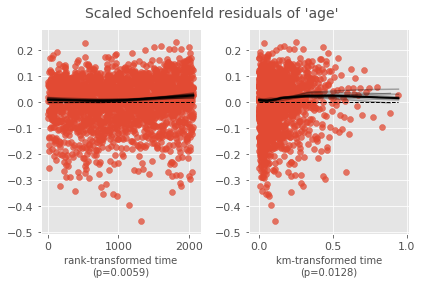

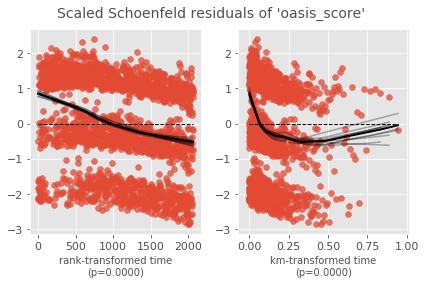

In [136]:
cph.check_assumptions(cohort[features], p_value_threshold=0.05, show_plots=True, advice=True)

#### Plotting the coefficients

With a fitted model, an alternative way to view the coefficients and their ranges is to use the plot method.

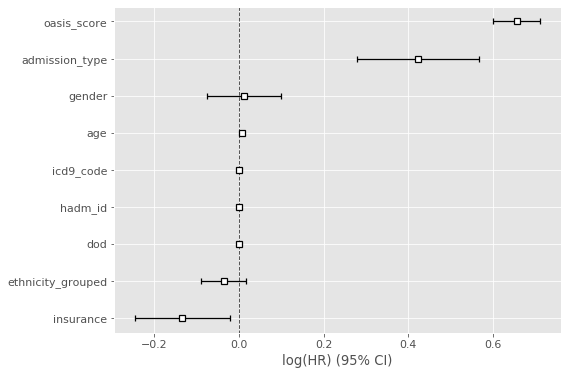

In [137]:
ax = plt.subplots(figsize=(8, 6))
cph.plot(ax=ax[1])

#### Plotting the effect of varying a covariate

After fitting, we can plot what the survival curves look like as we vary a single covariate while holding everything else equal. This is useful to understand the impact of a covariate, given the model.

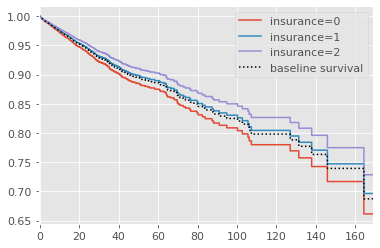

In [135]:
cph.plot_covariate_groups('insurance', values=[0, 1, 2]);

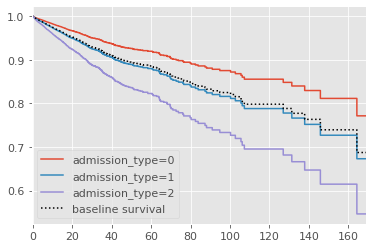

In [120]:
cph.plot_covariate_groups('admission_type', values=[0, 1, 2]);

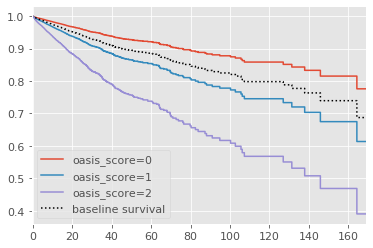

In [119]:
cph.plot_covariate_groups('oasis_score', values=[0, 1, 2]);